In [1]:
# importing neccessory libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import shap
import joblib
from imblearn.over_sampling import SMOTE
from collections import Counter  # To check class balance

c:\Users\brijesh maurya\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load & read dataset
file_path = 'Telecom_Customers_Churn.csv'
df = pd.read_csv(file_path)

df.dropna(inplace=True) # Drop null/ missing values

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# Fill missing TotalCharges with median value
df.fillna({'TotalCharges': df['TotalCharges'].median()}, inplace=True)

In [3]:
# Drop CustomerID as it's not useful for prediction
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)

In [4]:
def preprocess_data(df):
    df = df.copy()
    
    # Encoding categorical features
    label_encoders = {}
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
    for col in df.select_dtypes(include=['object']).columns.difference(['Churn']):
        le = LabelEncoder()
        if col != 'Churn': 
            df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    
    # Feature scaling
    scaler = StandardScaler()
    # feature_cols = [col for col in df.columns if col != 'Churn']
    numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
    # df[feature_cols] = scaler.fit_transform(df[feature_cols])
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    
    # Store feature names in a dictionary
    scaler_info = {
        "scaler": scaler,
        "numeric_cols": numeric_cols  # Store the names manually
    }
    
    return df, label_encoders, scaler_info

# Preprocess data
df_processed, label_encoders, scaler_info = preprocess_data(df)

# Display processed dataset summary
print(df_processed.head())
print(f"Class Distribution:\n{df_processed['Churn'].value_counts()}")

   gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  \
0       0              0        1           0 -1.277445             0   
1       1              0        0           0  0.066327             1   
2       1              0        0           0 -1.236724             1   
3       1              0        0           0  0.514251             0   
4       0              0        0           0 -1.236724             1   

   MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0              1                0               0             2   
1              0                0               2             0   
2              0                0               2             2   
3              1                0               2             0   
4              0                1               0             0   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                 0            0            0                0         0   
1     

In [5]:
# Split dataset into features (X) and target variable (y)
X = df_processed.drop(columns=['Churn'])
y = df_processed['Churn'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Check the new class distribution after SMOTE
print(f"Class Distribution after SMOTE:\n{pd.Series(y_train).value_counts()}")

Class Distribution after SMOTE:
Churn
0    4139
1    4139
Name: count, dtype: int64


In [6]:
# Train model
model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Display first few predictions
print("Sample Predictions:", y_pred[:10])

Sample Predictions: [0 1 0 0 0 1 1 0 0 0]


In [7]:
# Evaluate Model Performance
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}") # Evaluate model
print(f'AUC-ROC: {roc_auc_score(y_test, y_prob):.4f}')

print(classification_report(y_test, y_pred))

Accuracy: 0.7672
AUC-ROC: 0.8219
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1035
           1       0.55      0.64      0.59       374

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.77      0.77      1409



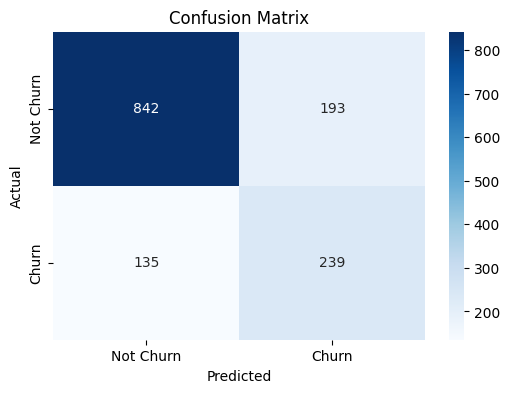

In [8]:
# Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=["Not Churn", "Churn"], yticklabels=["Not Churn", "Churn"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

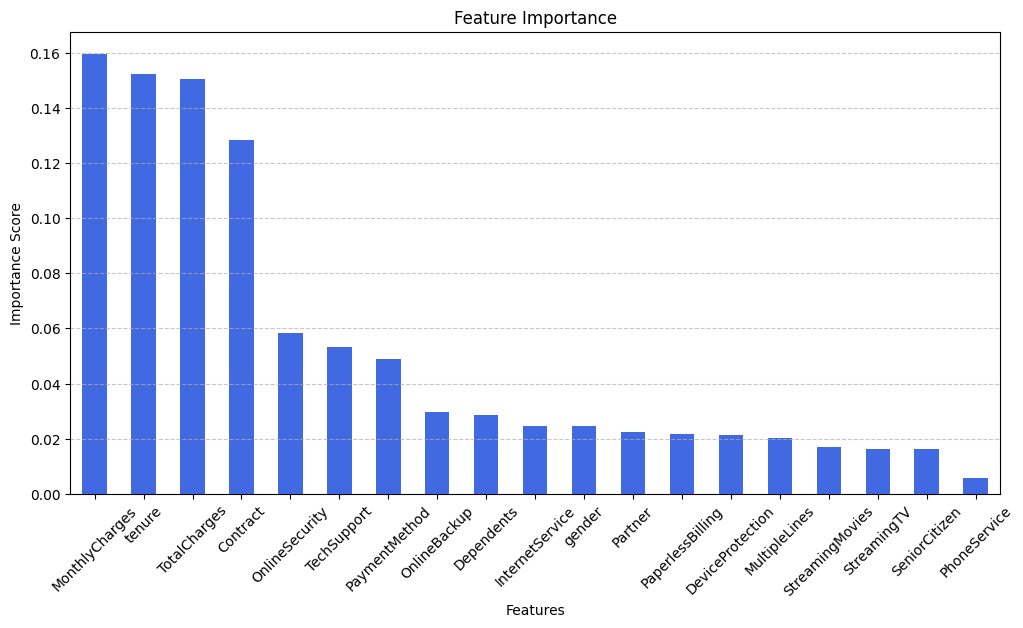

In [9]:
# Feature importance
importances = model.feature_importances_
feature_names = X.columns

# Create a sorted Series for better visualization
feat_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
feat_importances.plot(kind='bar', color="royalblue", title='Feature Importance')
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)  # Rotate for better visibility
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

<Figure size 1000x600 with 0 Axes>

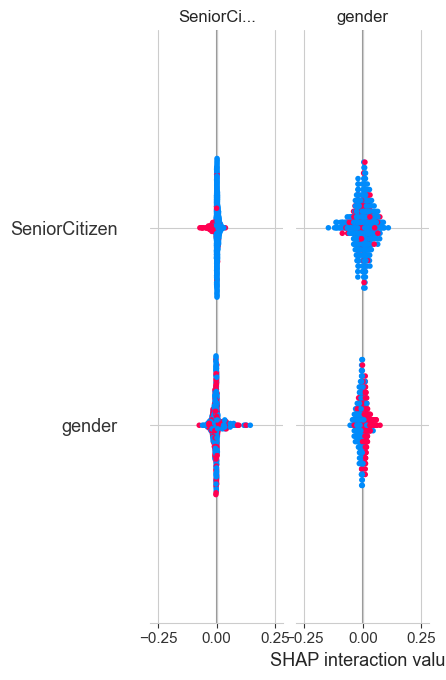

In [22]:
# SHAP Values for model explanation
explainer = shap.TreeExplainer(model)

# Sample only 500 rows for SHAP calculation
X_sample = X_train.sample(500, random_state=42)

# Compute SHAP values for the sample
shap_values_sample = explainer.shap_values(X_sample)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_sample, X_sample)

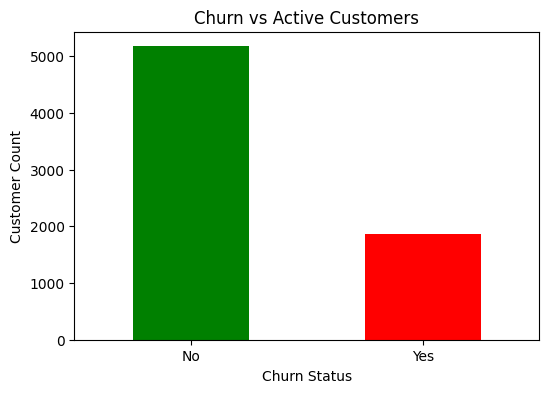

In [11]:
# Data Visualization Churn rate
plt.figure(figsize=(6, 4))
df['Churn'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title("Churn vs Active Customers")
plt.xlabel("Churn Status")
plt.ylabel("Customer Count")
plt.xticks(rotation=0)
plt.show()

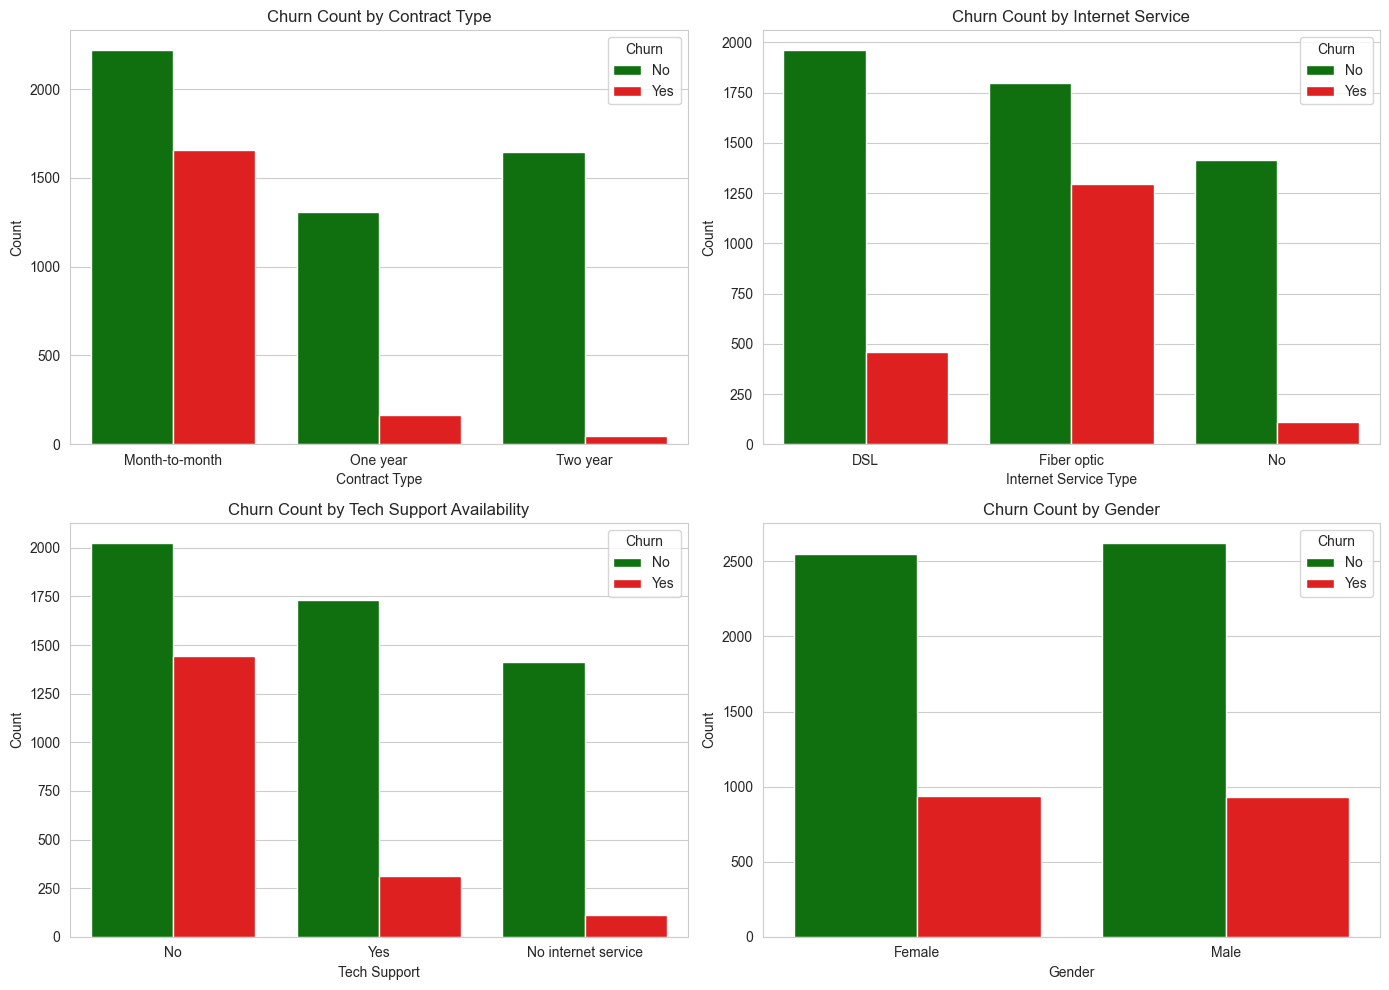

In [12]:
# Set style
sns.set_style("whitegrid")

# Set up figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Churn Count by Contract Type
sns.countplot(data=df, x="Contract", hue="Churn", ax=axes[0, 0], palette=["green", "red"])
axes[0, 0].set_title("Churn Count by Contract Type")
axes[0, 0].set_xlabel("Contract Type")
axes[0, 0].set_ylabel("Count")

# 2. Churn Count by Internet Service Type
sns.countplot(data=df, x="InternetService", hue="Churn", ax=axes[0, 1], palette=["green", "red"])
axes[0, 1].set_title("Churn Count by Internet Service")
axes[0, 1].set_xlabel("Internet Service Type")
axes[0, 1].set_ylabel("Count")

# 3. Churn Count by Tech Support Availability
sns.countplot(data=df, x="TechSupport", hue="Churn", ax=axes[1, 0], palette=["green", "red"])
axes[1, 0].set_title("Churn Count by Tech Support Availability")
axes[1, 0].set_xlabel("Tech Support")
axes[1, 0].set_ylabel("Count")

# 4. Churn Count by Gender
sns.countplot(data=df, x="gender", hue="Churn", ax=axes[1, 1], palette=["green", "red"])
axes[1, 1].set_title("Churn Count by Gender")
axes[1, 1].set_xlabel("Gender")
axes[1, 1].set_ylabel("Count")

# Adjust layout and show plots
plt.tight_layout()
plt.show()

In [13]:
def predict_churn(new_data, model, label_encoders, scaler_info):
    new_data = new_data.copy()
    
    # Extract stored scaler and feature names
    scaler = scaler_info["scaler"]
    numeric_cols = scaler_info["numeric_cols"]  # Retrieve manually stored column names
    expected_features = list(model.feature_names_in_)  # Model-trained features

    # Encode categorical features
    for col in label_encoders:
        if col in new_data.columns:
            new_data[col] = new_data[col].map(
                lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else -1
            )

    # Fill missing features with 0
    for col in expected_features:
        if col not in new_data.columns:
            new_data[col] = 0  

    # Reorder columns
    new_data = new_data[expected_features]

    # Scale only numerical columns
    new_data[numeric_cols] = scaler.transform(new_data[numeric_cols])

    # Make predictions
    churn_prediction = model.predict(new_data)
    churn_probability = model.predict_proba(new_data)[:, 1]

    return churn_prediction, churn_probability



# Example usage (replace with actual data)
new_customer = pd.DataFrame({
    "gender": ["Female"],
    "SeniorCitizen": [0],
    "Partner": ["Yes"],
    "Dependents": ["Yes"],
    "tenure": [36],
    "PhoneService": ["Yes"],
    "MultipleLines": ["Yes"],
    "InternetService": ["DSL"],
    "OnlineSecurity": ["Yes"],
    "OnlineBackup": ["Yes"],
    "DeviceProtection": ["Yes"],
    "TechSupport": ["Yes"],
    "StreamingTV": ["Yes"],
    "StreamingMovies": ["Yes"],
    "Contract": ["two year"],
    "PaperlessBilling": ["Yes"],
    "PaymentMethod": ["Bank transfer (automatic)"],
    "MonthlyCharges": [55.20],
    "TotalCharges": [1985.75]  # Ensure this remains numeric
})

# Make prediction
prediction, probability = predict_churn(new_customer, model, label_encoders, scaler_info)
if prediction[0] == 1:
    print("This customer is likely to churn!")
    print(f"Churn Probability: {probability[0]*100:.2f}%")
else:
    print("This customer is not likely to churn.")
    print(f"Churn Probability: {(1 - probability[0])*100:.2f}%")


This customer is not likely to churn.
Churn Probability: 79.00%


In [14]:
# Churn Customer data
# new_customer = pd.DataFrame({
#     "gender": ["Male"],
#     "SeniorCitizen": [1],
#     "Partner": ["No"],
#     "Dependents": ["No"],
#     "tenure": [6],
#     "PhoneService": ["Yes"],
#     "MultipleLines": ["No"],
#     "InternetService": ["Fiber optic"],
#     "OnlineSecurity": ["No"],
#     "OnlineBackup": ["No"],
#     "DeviceProtection": ["No"],
#     "TechSupport": ["No"],
#     "StreamingTV": ["Yes"],
#     "StreamingMovies": ["Yes"],
#     "Contract": ["Month-to-month"],
#     "PaperlessBilling": ["Yes"],
#     "PaymentMethod": ["Electronic check"],
#     "MonthlyCharges": [95.99],
#     "TotalCharges": [575.94]  # Ensure this remains numeric
# })

In [15]:
joblib.dump(model, "churn_model.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")
joblib.dump(scaler_info, "scaler_info.pkl")

['scaler_info.pkl']

In [16]:
# # Save the model and scaler
# joblib.dump(model, "churn.pkl")  # Save model
# joblib.dump(scaler_info, "scaler1.pkl")  # Save scaler if used
# joblib.dump(label_encoders, "label_encoders.pkl") 